In [1]:
import os
import cv2
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range
from tqdm.notebook import tqdm
from pandas import read_pickle

import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
config = {}

config['camera'] = "01"

# config['path_to_data'] = data_path+"ids/cut/"
config['path_to_data'] = archive_path+f"ids/images{config['camera']}/"

config['path_to_outdata'] = data_path+f"ids/data{config['camera']}/"

# config['date1'] = "2024-03-08"
# config['date2'] = "2024-03-09"

# example for ""
config['figure_name'] = "20240603_002505.png"

# example for "01"
# config['figure_name'] = "20240705_235806.png"

# # example for 03
# config['figure_name'] = "20240502_171604.png"
# config['figure_name'] = "20240707_223506.png"

# # example for 07
# config['figure_name'] = "20240502_164604.png"
config['figure_name'] = "20240708_000406.png"

# only evaluate every nth image
config['nth'] = 10

# initial guess of parameters [ amplitude, xo, yo, sigma_x, sigma_y, theta, offset ]
config['initial_guess'] = {"": (255, 2000, 1000, 500, 500, 0, 0),
                           "01": (255, 700, 550, 500, 500, 0, 0),
                           "03": (255, 500, 350, 500, 500, 0, 0),
                           "07": (255, 450, 450, 500, 500, 0, 0),
                          }

In [4]:
def __store_as_pickle(obj, filename):

    import pickle
    from os.path import isdir

    ofile = open(filename, 'wb')
    pickle.dump(obj, ofile)

    if isdir(filename):
        print(f"created: {filename}")

In [5]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):

    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

    return g.ravel()

In [6]:
def __makeplot():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    maxY, maxX = im.shape

    font = 12

    Nrow, Ncol = 4, 6

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5, wspace=0.45)

    ax1 = fig.add_subplot(gs[0:4, :4])
    ax2 = fig.add_subplot(gs[0:2, 4:])
    ax3 = fig.add_subplot(gs[2:4, 4:])

    ax1.imshow(im, cmap=plt.get_cmap("gray"));
    ax1.contour(x, y, im_fitted);
    ax1.scatter(x_max, y_max, color="red", marker="d");

    ax1.axvline(x_max, 0, maxY, color="tab:orange", ls=":", zorder=1, alpha=0.4)
    ax1.axhline(y_max, 0, maxX, color="tab:blue", ls=":", zorder=1, alpha=0.4)

    ax2.plot(im[y_max, :], color="tab:blue", zorder=2)
    ax2.plot(im_fitted[y_max, :], color="black", ls="--", zorder=2)
    ax2.axvline(x_max, 0, im_fitted[y_max, x_max], color="red", ls="--", zorder=1, label=f"X = {x_max}")

    ax3.plot(im[:, x_max], color="tab:orange", zorder=2)
    ax3.plot(im_fitted[:, x_max], color="black", ls="--", zorder=2)
    ax3.axvline(y_max, 0, im_fitted[y_max, x_max], color="red", ls="--", zorder=1, label=f"Y = {y_max}")


    ax1.set_xlabel("Pixel X", fontsize=font)
    ax1.set_ylabel("Pixel Y", fontsize=font)
    ax2.set_xlabel("Pixel X", fontsize=font)
    ax3.set_xlabel("Pixel Y", fontsize=font)

    ax2.set_ylabel("Intensity", fontsize=font)
    ax3.set_ylabel("Intensity", fontsize=font)

    ax2.set_ylim(0, 255)
    ax3.set_ylim(0, 255)

    ax2.legend()
    ax3.legend()

    ax1.set_ylim(0, maxY)
    ax1.set_xlim(0, maxX)
    ax2.set_xlim(0, maxX)
    ax3.set_xlim(0, maxY)

    ax2.grid(zorder=0, color="grey", ls="--", alpha=0.5)
    ax3.grid(zorder=0, color="grey", ls="--", alpha=0.5)

    ax1.text(0.01, 0.98, "(a)", ha="left", va="top", transform=ax1.transAxes, fontsize=font+1, color="w")
    ax2.text(0.01, 0.98, "(b)", ha="left", va="top", transform=ax2.transAxes, fontsize=font+1, color="k")
    ax3.text(0.01, 0.98, "(c)", ha="left", va="top", transform=ax3.transAxes, fontsize=font+1, color="k")


    plt.show();
    return fig

20240708_000406.png


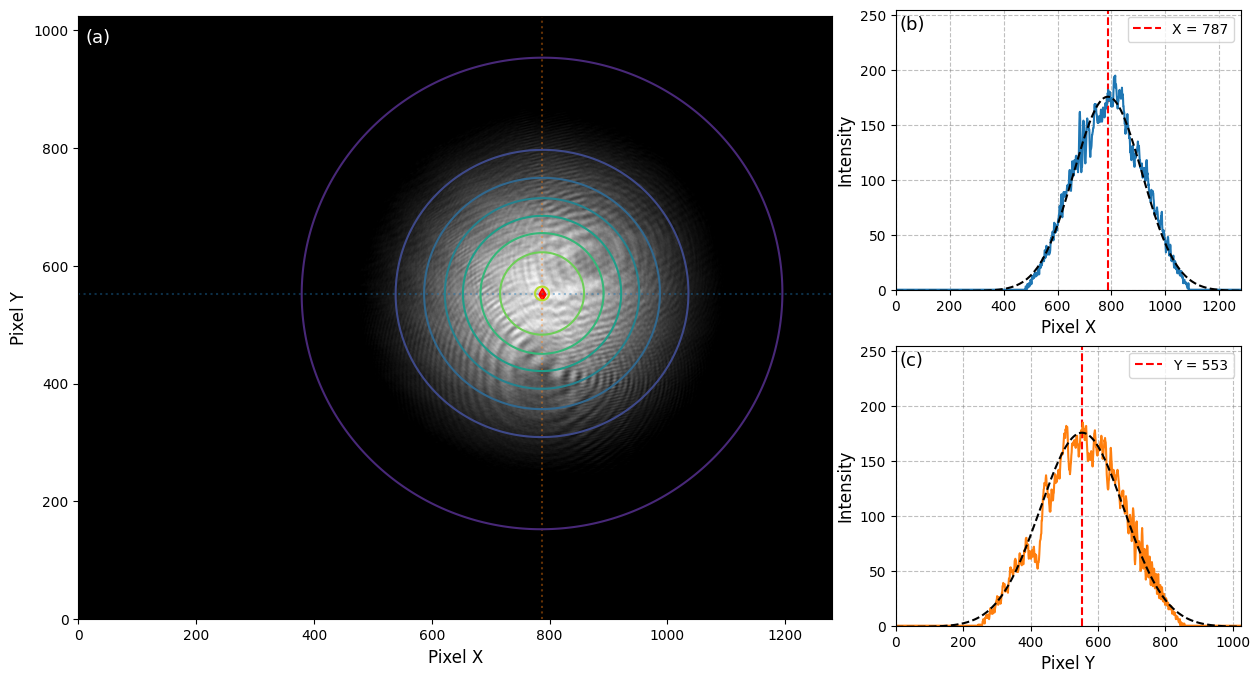

In [7]:

# load last estimate as intial guess
try:
    guess = read_pickle(config['path_to_outdata']+"tmp/"+f"{config['camera']}_initial_guess.pkl")
    config['initial_guess'][config['camera']] = guess
except:
    print(f" -> failed to load initial guess")

## get date as str
date_str = str(config['figure_name'])[:8]

## modife path to image
path_to_data = f"{config['path_to_data']}{date_str.replace('-','')}/"

## dummy data
dummy = np.nan

## prepare output dataframe
df_out = DataFrame()

## set dummy values
for col in ["time", "x", "y", "x_idx", "y_idx", "amp", "x_sig", "y_sig", "theta", "offset", "x_var", "y_var", "amp_var", "y_sig_var", "x_sig_var", "theta_var", "offset_var"]:
    df_out[col] = dummy


print(config['figure_name'])

## load image and get dimensions
try:
    im = cv2.imread(path_to_data+config['figure_name'], -1)
    h, w = im.shape
    data = im.ravel()

except:
    print(f" -> failed to load image: {config['figure_name']}")

# cmap = plt.get_cmap("gray")
# plt.imshow(im, cmap=cmap)
# plt.show();

## prepare x-y-mesh
x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
x, y = np.meshgrid(x, y)

# initial guess of parameters [ amplitude, xo, yo, sigma_x, sigma_y, theta, offset ]
initial_guess = config['initial_guess'][config['camera']]

try:

    # find the optimal Gaussian parameters
    popt, pcov = curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess)

    # create new data with these parameters
    data_fitted = twoD_Gaussian((x, y), *popt)

except:
    print("-> fitting failed")

## get diagonal values
pcov_diag = np.diag(pcov)

# reshape to image dimensions
im_fitted = data_fitted.reshape(h, w)

## get maximum of 2d fit
y_max, x_max = np.argwhere(im_fitted == im_fitted.max())[0]

_date_str = config['figure_name'].split('.')[0].split('_')[0]
_time_str = config['figure_name'].split('.')[0].split('_')[1]

df_out.loc['time'] = str(UTCDateTime(_date_str+"T"+_time_str))

df_out.loc['y_idx'] = y_max
df_out.loc['x_idx'] = x_max

df_out.loc['amp'] = popt[0]
df_out.loc['x'] = popt[1]
df_out.loc['y'] = popt[2]
df_out.loc['x_sig'] = popt[3]
df_out.loc['y_sig'] = popt[4]
df_out.loc['theta'] = popt[5]
df_out.loc['offset'] = popt[6]

df_out.loc['amp_var'] = pcov_diag[0]
df_out.loc['x_var'] = pcov_diag[1]
df_out.loc['y_var'] = pcov_diag[2]
df_out.loc['x_sig_var'] = pcov_diag[3]
df_out.loc['y_sig_var'] = pcov_diag[4]
df_out.loc['theta_var'] = pcov_diag[5]
df_out.loc['offset_var'] = pcov_diag[6]



# fig = plt.figure();
# plt.imshow(im, cmap=plt.get_cmap("gray"));
# plt.contour(x, y, im_fitted);
# plt.scatter(x_max, y_max, color="red", marker="d");
# plt.show();

fig = __makeplot();

# fig.savefig(config['path_to_outdata']+"outfigs/"+f"{config['figure_name'][:-4]}_mod.png", format="png", dpi=150, bbox_inches='tight');

# make tmp directory if not existent
if not os.path.isdir(config['path_to_outdata']+"tmp/"):
    os.mkdir(config['path_to_outdata']+"tmp/")

# write current maximum estimate to file for next inital guess
__store_as_pickle(popt, config['path_to_outdata']+"tmp/"+f"{config['camera']}_initial_guess.pkl")

## sort for time column
# df_out.sort_values(by="time", inplace=True)

df_out

## write output data frame
# df_out.to_pickle(config['path_to_outdata']+f"{date_str}.pkl")


# cv2.imwrite(r"path_to_save\data_fitted.png", data_fitted.reshape(h,w))

gc.collect();


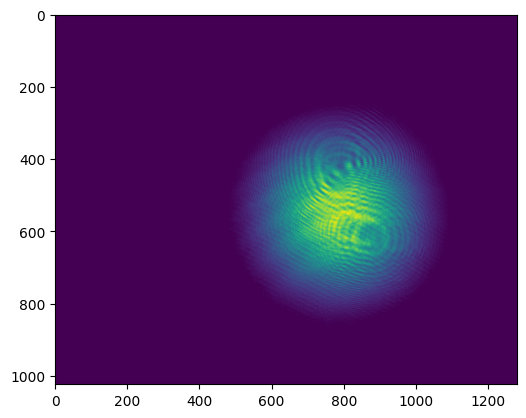

In [8]:
plt.imshow(im)

In [9]:
im.shape

(1024, 1280)